# Environment Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pathlib
import IPython.display as display
import random
import pandas as pd
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
import time

In [3]:
%cd drive

/content/drive


In [4]:
%cd MyDrive

/content/drive/MyDrive


In [5]:
%cd ML\ \&\ Climate

/content/drive/MyDrive/ML & Climate


In [6]:
! ls

 cache.tf-data.data-00000-of-00001   test_v2_file_mapping.csv.zip
 cache.tf-data.index		     train-jpg
'ML & Climate EDA.ipynb'	     train-jpg.tar
 test-jpg			     train-tif-v2.tar.7z
 test-jpg.tar			     train_v2.csv
 test-jpg.tar.7z		     train_v2.csv.zip
 test-tif-v2.tar.7z


In [ ]:
#!tar -xvf 'train-jpg.tar'

# Training Set

In [7]:
data_root = pathlib.Path("/content/drive/MyDrive/ML & Climate/train-jpg")

In [9]:
all_img_paths = list(data_root.glob('*'))

In [10]:
all_img_paths = [str(path) for path in all_img_paths]

In [11]:
len(all_img_paths)

40479

In [12]:
all_img_paths[:5]

['/content/drive/MyDrive/ML & Climate/train-jpg/train_9443.jpg',
 '/content/drive/MyDrive/ML & Climate/train-jpg/train_9395.jpg',
 '/content/drive/MyDrive/ML & Climate/train-jpg/train_9322.jpg',
 '/content/drive/MyDrive/ML & Climate/train-jpg/train_9499.jpg',
 '/content/drive/MyDrive/ML & Climate/train-jpg/train_9385.jpg']

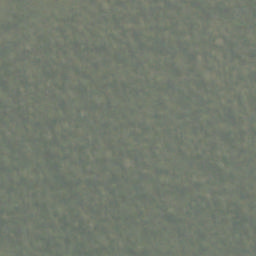

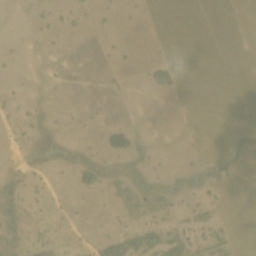

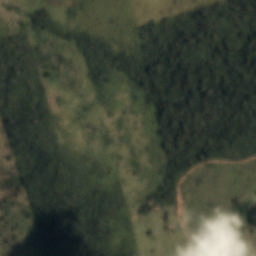

In [13]:
for n in range(3):
  image_path = random.choice(all_img_paths)
  display.display(display.Image(image_path))

# Test Set

In [ ]:
#!7z x 'test-jpg.tar.7z'

In [ ]:
#!tar -xvf  'test-jpg.tar'

In [ ]:
test_root = pathlib.Path("/content/drive/MyDrive/ML & Climate/test-jpg")

In [ ]:
test_img_paths = list(test_root.glob('*'))

In [ ]:
test_img_paths = [str(path) for path in test_img_paths]

In [ ]:
len(test_img_paths)

24038

In [ ]:
test_img_paths[:5]

['/content/drive/MyDrive/ML & Climate/test-jpg/test_8452.jpg',
 '/content/drive/MyDrive/ML & Climate/test-jpg/test_8563.jpg',
 '/content/drive/MyDrive/ML & Climate/test-jpg/test_8615.jpg',
 '/content/drive/MyDrive/ML & Climate/test-jpg/test_8596.jpg',
 '/content/drive/MyDrive/ML & Climate/test-jpg/test_8531.jpg']

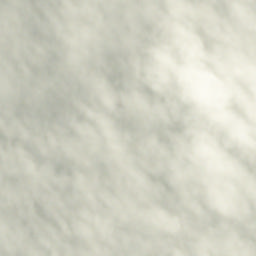

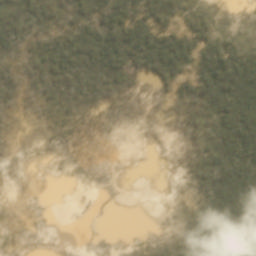

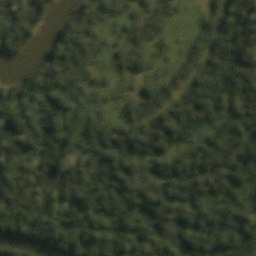

In [ ]:
for n in range(3):
  image_path = random.choice(all_img_paths)
  display.display(display.Image(image_path))

# Data Labels

In [14]:
labels = pd.read_csv("train_v2.csv")

In [15]:
labels

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


There is no labels for the test set, since this is a kaggle competition. Will have to split the training set in to train, val, and test.

Here are the label distributions:

In [16]:
tags = defaultdict(lambda: 0)
for each in labels['tags']:
  tag_list = each.split(" ")
  for tag in tag_list:
    tags[tag] += 1

In [17]:
tags

defaultdict(<function __main__.<lambda>()>,
            {'haze': 2697,
             'primary': 37513,
             'agriculture': 12315,
             'clear': 28431,
             'water': 7411,
             'habitation': 3660,
             'road': 8071,
             'cultivation': 4547,
             'slash_burn': 209,
             'cloudy': 2089,
             'partly_cloudy': 7261,
             'conventional_mine': 100,
             'bare_ground': 862,
             'artisinal_mine': 339,
             'blooming': 332,
             'selective_logging': 340,
             'blow_down': 101})

In [18]:
deforest_tags = {}
# these are the tags that we are considering as deforestation
deforestation = ['agriculture', 'cultivation', 'slash_burn', 'conventional_mine', 'artisinal_mine',
                 'selective_logging', 'road', 'habitation']    
for tag, count in tags.items():
  if tag in deforestation:
    deforest_tags[tag] = count

In [19]:
deforest_tags

{'agriculture': 12315,
 'habitation': 3660,
 'road': 8071,
 'cultivation': 4547,
 'slash_burn': 209,
 'conventional_mine': 100,
 'artisinal_mine': 339,
 'selective_logging': 340}

In [20]:
deforestation_count = 0
for each in labels['tags']:
  tag_list = each.split(" ")
  for tag in tag_list:
    if tag in deforest_tags:
      deforestation_count += 1
      break

In [21]:
print("Total counts of deforestation: ", deforestation_count)
print("The percentage of deforestation labels: ", 
      deforestation_count/len(labels))

Total counts of deforestation:  15899
The percentage of deforestation labels:  0.39277156056226686


The dataset is somewhat balanced, with around 40% positive labels (deforestation) and 60% negative labels (no deforestation).

**Binary Data Labels**

First run, try to encode all training example into either has some classification of deforestation or not.

In [22]:
pathlib.Path(all_img_paths[0]).name.split(".")[0]

'train_9443'

In [23]:
bin_labels = {} # binary 0/1 labels for whether img has deforestation
i = 0
for each in labels["tags"]:
  tags = each.split(" ")
  for t in tags:
    if t in deforest_tags:
      # 1 for deforestation, 0 for no deforestation
      bin_labels[labels.loc[i]["image_name"]] = 1
      break
  if labels.loc[i]["image_name"] not in bin_labels:
    bin_labels[labels.loc[i]["image_name"]] = 0
  i += 1

In [24]:
# an array of the binary labels to feed into train-test-split
all_bin_labels = [bin_labels[pathlib.Path(path).name.split(".")[0]]
                  for path in all_img_paths]

In [25]:
count = 0
for each in all_bin_labels:
  count += each
print("deforestation: ", count, "\nno deforestation: ", len(all_bin_labels)-count)

deforestation:  15899 
no deforestation:  24580


# Modeling

In [26]:
train_paths, test_paths, train_labels, test_labels = train_test_split(all_img_paths, 
                                                                      all_bin_labels,
                                                                      test_size=0.25, 
                                                                      random_state=42)

Display a few images and their labels

0


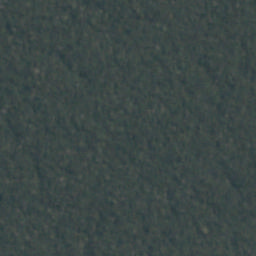


1


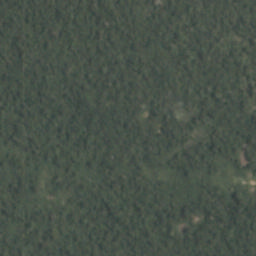


0


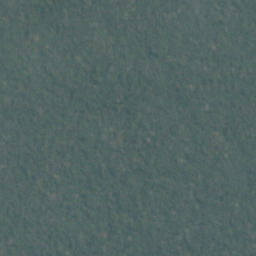

In [27]:
for n in range(3):
  i = random.randint(0,len(train_paths))
  image_path = train_paths[i]
  print(train_labels[i])
  display.display(display.Image(image_path))
  print()

In [28]:
img_raw = tf.io.read_file(train_paths[0])
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x0...


In [29]:
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)

(256, 256, 3)
<dtype: 'uint8'>


**Parameters for loader**

In [30]:
BATCH_SIZE = 128
IMG_SIZE = 180
AUTOTUNE = tf.data.experimental.AUTOTUNE
SHUFFLE_SIZE = 1000
BUFFER_SIZE = 1000

In [31]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE ])
  img /= 255.0  # normalize pixels to 0,1
  return img

Checking the shapes of the preprocessed dataset:

In [32]:
# a dataset that returns image paths
path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
for n, img_path in enumerate(path_ds.take(4)):
  print(n, img_path)

0 tf.Tensor(b'/content/drive/MyDrive/ML & Climate/train-jpg/train_7173.jpg', shape=(), dtype=string)
1 tf.Tensor(b'/content/drive/MyDrive/ML & Climate/train-jpg/train_17589.jpg', shape=(), dtype=string)
2 tf.Tensor(b'/content/drive/MyDrive/ML & Climate/train-jpg/train_32572.jpg', shape=(), dtype=string)
3 tf.Tensor(b'/content/drive/MyDrive/ML & Climate/train-jpg/train_3785.jpg', shape=(), dtype=string)


In [33]:
# a dataset that returns images (loaded off disk, decoded, and preprocessed)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
for n, image in enumerate(image_ds.take(4)):
  print(n, image.shape)

0 (180, 180, 3)
1 (180, 180, 3)
2 (180, 180, 3)
3 (180, 180, 3)


In [34]:
# a dataset that returns labels
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int64))
for label in label_ds.take(4):
  print(label.numpy())

0
0
1
0


In [35]:
# a dataset that returns images and labels
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset element_spec=(TensorSpec(shape=(180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [36]:
for img, label in image_label_ds.take(2):
  print(img.shape, label.numpy())

(180, 180, 3) 0
(180, 180, 3) 0


In [37]:
train_ds = image_label_ds.shuffle(SHUFFLE_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

for img, label in train_ds.take(2):
  print(img.shape, label.shape) # notice it's returning batches of data now

(128, 180, 180, 3) (128,)
(128, 180, 180, 3) (128,)


Benchmark Utility to test runtime:

In [38]:
# A benchmark utility to time how long it takes
# to iterate once over the entire dataset
def time_one_epoch(ds):
  start = time.time()
  batches = 0
  for i,(images,labels) in enumerate(ds):
    batches += 1
    if i % 10 == 0:
      print('.', end='')
  print()
  end = time.time()
  duration = end-start
  print("Read {} batches".format(batches))
  print("{:0.2f} Batches/s".format(batches/duration))
  print("{:0.2f} Images/s".format(BATCH_SIZE*batches/duration))
  print("Total time: {}s".format(duration))

Use on-disk caching.
Make a train dataset.

In [39]:
# making your training dataset with image and label pairs
train_ds = image_label_ds.cache(filename='./cache.tf-data')
train_ds = train_ds.shuffle(buffer_size=BUFFER_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [40]:
# REMOVE LATER
small_train_ds = train_ds.take(1)

In [41]:
# REMOVE LATER
len(train_ds) # number of batches

238

In [42]:
# REMOVE LATER
small_train_ds

<TakeDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [43]:
time_one_epoch(small_train_ds) # this will be slow

.
Read 1 batches
0.14 Batches/s
17.45 Images/s
Total time: 7.334843397140503s


Now that the cache is built, iteration will be much faster.

In [44]:
time_one_epoch(small_train_ds) # this will be fast

.
Read 1 batches
0.79 Batches/s
101.13 Images/s
Total time: 1.2656972408294678s


Make a test dataset

In [45]:
# let's make a test dataset as well
path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
test_ds = image_label_ds.cache(filename='./test_cache.tf-data')
test_ds = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE) # added this line to fix dim mismatch

In [46]:
# REMOVE LATER
small_test_ds = test_ds.take(1)

In [47]:
# REMOVE LATER - Now we have the correct size
small_test_ds

<TakeDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [48]:
my_model = models.Sequential()
my_model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
my_model.add(layers.MaxPooling2D())
my_model.add(layers.Conv2D(64, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
my_model.add(layers.MaxPooling2D())
my_model.add(layers.Flatten())
my_model.add(layers.Dense(128, activation="relu"))
my_model.add(layers.Dense(2, activation="softmax"))

In [49]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 118336)            0         
                                                                 
 dense (Dense)               (None, 128)               1

In [50]:
my_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
my_model.fit(small_train_ds, validation_data=small_test_ds, epochs=5)

Epoch 1/5
1/1 [==============================] - 46s 46s/step - loss: 0.6931 - accuracy: 0.5938 - val_loss: 0.6929 - val_accuracy: 0.6016
Epoch 2/5
1/1 [==============================] - 11s 11s/step - loss: 0.6930 - accuracy: 0.5625 - val_loss: 0.6927 - val_accuracy: 0.6016
Epoch 3/5
1/1 [==============================] - 9s 9s/step - loss: 0.6927 - accuracy: 0.6172 - val_loss: 0.6926 - val_accuracy: 0.6016
Epoch 4/5
1/1 [==============================] - 10s 10s/step - loss: 0.6927 - accuracy: 0.5703 - val_loss: 0.6924 - val_accuracy: 0.6016
Epoch 5/5
1/1 [==============================] - 9s 9s/step - loss: 0.6923 - accuracy: 0.6094 - val_loss: 0.6922 - val_accuracy: 0.6016


In [ ]:
# Now the training works on the small batch dataset, when have time and a stable internet connection
# will train on the whole dataset to find accuracy and see where improvement needs to be made